In [1]:
import warnings
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import pandas as pd
import numpy as np

warnings.filterwarnings('ignore')

In [2]:
data = fdr.DataReader('005930')
data

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2000-01-14,5720,5880,5680,5830,987576,NaN
2000-01-17,6000,6180,5920,6100,1270138,0.046312
2000-01-18,6160,6160,5980,6100,905231,0.000000
2000-01-19,6000,6040,5960,5960,804159,-0.022951
2000-01-20,5860,6040,5820,6040,746360,0.013423
...,...,...,...,...,...,...
2024-04-29,77400,77600,76200,76700,14664474,0.000000
2024-04-30,77000,78500,76600,77500,19007007,0.010430
2024-05-02,77600,78600,77300,78000,18900640,0.006452


In [3]:
close = data['Close']

start_data = '2021-10-01'
end_data = '2023-12-22'

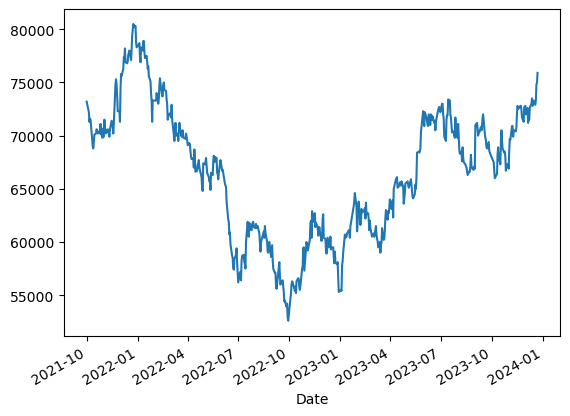

In [4]:
#기존 구간 시계열 차트
close[start_data:end_data].plot();

In [5]:
#기준점이 되는 종가의 범위 부분을 base에 넣음
base = close[start_data:end_data]
base

Date
2021-10-01    73200
2021-10-05    72200
2021-10-06    71300
2021-10-07    71600
2021-10-08    71500
              ...  
2023-12-18    72900
2023-12-19    73400
2023-12-20    74800
2023-12-21    75000
2023-12-22    75900
Name: Close, Length: 551, dtype: int64

In [6]:
#모든 수의 범위를 0과 1 사이로 정교한 진행
base_norm = (base - base.min()) / (base.max() - base.min())
base_norm

Date
2021-10-01    0.738351
2021-10-05    0.702509
2021-10-06    0.670251
2021-10-07    0.681004
2021-10-08    0.677419
                ...   
2023-12-18    0.727599
2023-12-19    0.745520
2023-12-20    0.795699
2023-12-21    0.802867
2023-12-22    0.835125
Name: Close, Length: 551, dtype: float64

In [7]:
#윈도우 사이즈(중간에 휴일을 제거한 날짜수)
window_size = len(base)
#예측 기간
next_date = 5
#검색 횟수
moving_cnt = len(close) - window_size - next_date - 1

In [8]:
#코사인 유사도 1에 가까울수록 유사성 up 
def cosine_similarity(x,y):
    return np.dot(x,y) / (np.sqrt(np.dot(x,x)) * np.sqrt(np.dot(y,y)))

In [9]:
#유사도 저장 딕셔너리
sim_list = []

for i in range(moving_cnt):
    target = close[i:i+window_size]
    #Normalize
    target_norm = (target - target.min()) / (target.max() - target.min())
    #코사인 유사도 저장
    cos_similarity = cosine_similarity(base_norm, target_norm)
    #코사인 유사도 <- i(인덱스), 시계열 데이터 함께 저장
    sim_list.append(cos_similarity)

In [10]:
#코사인 유사도를 기준으로 내림차순 정리
pd.Series(sim_list).sort_values(ascending = False).head(20)

5361    1.000000
5362    0.998255
5360    0.998252
5359    0.996547
5363    0.996546
5364    0.995234
5358    0.995207
5365    0.993892
5357    0.993841
5366    0.992657
5356    0.992560
5367    0.991632
5355    0.991386
5368    0.990362
5354    0.989972
5369    0.989183
5353    0.988641
5370    0.987970
5352    0.987234
5371    0.986256
dtype: float64

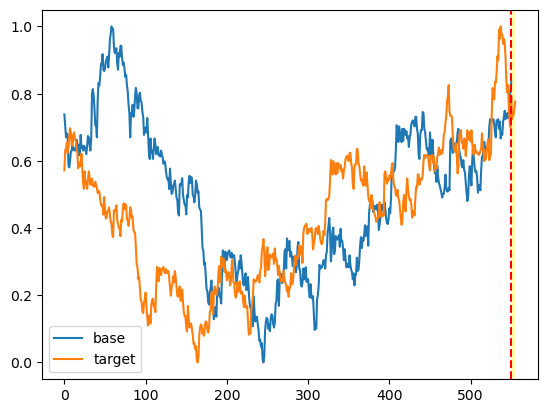

In [11]:
idx = 5442 
top_=close[idx:idx+window_size+next_date]
top_norm = (top_-top_.min()) / (top_.max()-top_.min())

plt.plot(base_norm.values, label = 'base')
plt.plot(top_norm.values, label = 'target')
plt.axvline(x=len(base_norm)-1, c='r', linestyle='--')
plt.axvspan(len(base_norm.values)-1, len(top_norm.values)-1, facecolor='yellow', alpha=0.3)
plt.legend()
plt.show()

In [12]:
class PatternFinder():
    def __init__(self, period=10): #days
        self.period = period
    
    def set_stock(self, code: str):
        self.code = code
        self.data = fdr.DataReader(code)
        self.close = self.data['Close']
        self.change = self.data['Change']
        return self.data
        
    def search(self, start_date, end_date, threshold=0.96): #cosine_sims_per
        base = self.close[start_date:end_date]
        self.base_norm = (base - base.min()) / (base.max() - base.min())
        self.base = base

        window_size = len(base)
        moving_cnt = len(self.data) - window_size - self.period - 1
        cos_sims = self.__cosine_sims(moving_cnt, window_size)
        
        self.window_size = window_size
        cos_sims = cos_sims[cos_sims > threshold]
        return cos_sims
    
    
    def __cosine_sims(self, moving_cnt, window_size):
        def cosine_similarity(x, y):
            return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))
        
        # 유사도 저장 딕셔너리
        sim_list = []

        for i in range(moving_cnt):
            target = self.close[i:i+window_size]

            # Normalize
            target_norm = (target - target.min()) / (target.max() - target.min())

            # 코사인 유사도 저장
            cos_similarity = cosine_similarity(self.base_norm, target_norm)

            # 코사인 유사도 <- i(인덱스), 시계열데이터 함께 저장
            sim_list.append(cos_similarity)
        return pd.Series(sim_list).sort_values(ascending=False)

    
    def plot_pattern(self, idx, period=10): #days
        if period != self.period:
            self.period = period
            
        top = self.close[idx:idx+self.window_size+period]
        top_norm = (top - top.min()) / (top.max() - top.min())
        fig = Figure()
        axis = fig.add_subplot(1, 1, 1)
        axis.plot(self.base_norm.values, label='base', color='black',  alpha=0.7)
        axis.plot(top_norm.values, label='prediction', color='red', linestyle='dashed')
        axis.plot(top_norm.values[:len(self.base_norm.values)], label='pattern', color='green', linestyle='solid')
        axis.axvline(x=len(self.base_norm)-1, c='tomato', linestyle='dotted')
        axis.axvspan(len(self.base_norm.values)-1, len(top_norm.values)-1, facecolor='yellow', alpha=0.3)
        axis.legend()
        axis.get_yaxis().set_visible(False)
        axis.get_xaxis().set_visible(False)
        
        preds = self.change[idx+self.window_size: idx+self.window_size+period]
        print(f'pred: {preds.mean()*100} % ')
        return fig

    def stat_prediction(self, results, period=10): #days
        idx_list = list(results.keys())
        mean_list = []
        for idx in idx_list:
            pred = self.change[idx+self.window_size: idx+self.window_size+period]
            mean_list.append(pred.mean())
        return np.array(mean_list)

In [13]:
p=PatternFinder()

In [20]:
p.set_stock('035420') #stock code

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2002-10-29,2312,2312,2312,2312,20549,NaN
2002-10-30,2587,2587,2558,2588,853638,0.119377
2002-10-31,2626,2689,2398,2459,1320880,-0.049845
2002-11-01,2520,2599,2215,2305,750761,-0.062627
2002-11-04,2285,2300,2135,2191,692165,-0.049458
...,...,...,...,...,...,...
2024-04-29,182200,184800,181600,184700,510519,0.017631
2024-04-30,184600,187500,183800,184400,620050,-0.001624
2024-05-02,185200,190000,184600,188800,1046087,0.023861


In [24]:
result = p.search('2023-11-01', '2024-05-06') #period


In [25]:
result

3729    0.969456
3726    0.969181
3730    0.968699
3728    0.968631
3727    0.968315
3725    0.967753
3724    0.967637
3582    0.966447
3731    0.966093
3723    0.965877
3583    0.965827
3722    0.964079
3581    0.963645
3584    0.963275
3732    0.962594
3586    0.962390
3721    0.962290
3580    0.961924
3585    0.961545
3587    0.960729
1314    0.960281
3579    0.960226
1313    0.960044
dtype: float64

pred: -0.047825664672027646 % 


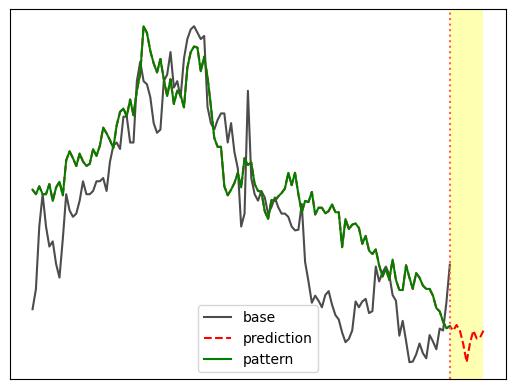

In [26]:
p.plot_pattern(3729) #cosine_sim_code